## <center> **Livrable n°1 : Classification binaire** </center>

‎ 

Réalisé par le **groupe n°2** :
- BERTHO Lucien
- BOSACKI Paul
- GAURE Warren
- GRENOUILLET Théo
- VALLEMONT Hugo


‎

---


### **Sommaire**

1. [Mise en contexte](#contexte)
2. [Objectif du livrable](#objectif)
3. [Importation des bibliothèques](#import)
4. [Préparation et chargement des données](#load)
5. [Exploration et visualisation des données](#exploration)
6. [Configuration de l'environnement](#configuration)
7. [Choix de l'architecture](#architecture)
8. [Réalisation du modèle](#modele)
9.  [Entraînement et évaluation du modèle](#train)
10. [Amélioration du modèle](#amelioration)
11. [Tuning des paramètres du modèle](#tuning)
12. [Modèle final](#final)
13. [Conclusion](#conclusion)

‎ 

---

### 1. <a id='contexte'>Mise en contexte</a>

L’entreprise TouNum est spécialisée dans la numérisation de documents, qu’il s’agisse de textes ou d’images. Ses services sont particulièrement sollicités par des entreprises cherchant à transformer leur base documentaire papier en fichiers numériques exploitables. Aujourd’hui, TouNum souhaite aller plus loin en enrichissant son offre avec des outils basés sur le Machine Learning.

En effet, certains clients disposent d’un volume considérable de documents à numériser et expriment un besoin croissant pour des solutions de catégorisation automatique. Une telle innovation leur permettrait d’optimiser le traitement et l’exploitation de leurs données numérisées. Toutefois, TouNum ne dispose pas en interne des compétences nécessaires pour concevoir et mettre en place ces technologies.

C’est dans ce cadre que notre équipe de spécialistes en Data Science du CESI est sollicitée. Notre mission consiste à développer une première solution intégrant du captioning automatique : un système capable d’analyser des photographies et de générer une légende descriptive de manière autonome.

Heureusement, TouNum possède déjà plusieurs milliers d’images annotées, ce qui constituera une ressource précieuse pour entraîner les modèles de Machine Learning à partir d’un apprentissage supervisé.

---

### 2. <a id='objectif'>Objectif du livrable</a>

TouNum souhaite automatiser la sélection des photos destinées à l'annotation. Ce livrable propose une méthode de classification basée sur les réseaux de neurones pour filtrer les images qui ne sont pas des photos. La solution reposera sur l'architecture de réseau retenue en fonction des résultats obtenus.

---

### 3. <a id='import'>Importation des bibliothèques</a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import collections
import os
import datetime
import keras_tuner as kt

from concurrent.futures import ThreadPoolExecutor, as_completed
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

---

### 4. <a id='load'>Préparation et chargement des données</a>

Une fois les bibliothèques importées, nous pouvons commencer à préparer le terrain en amont et charger les données pour qu'elles puissent être utilisées dans notre pipeline.

#### 4.1. <a>Vérification des images</a>

Tout d'abord, nous devons nous assurer du bon état des images reçues, c'est-à-dire vérifier si elles n'ont pas été corrompues ou mal formatées.

In [3]:
dataset_directory = "dataset_livrable_1/"

In [4]:
def is_valid_image(path):
    try:
        img_raw = tf.io.read_file(path)
        _ = tf.image.decode_image(img_raw, channels=3)
        return (path, True)
    except Exception:
        return (path, False)

def clean_corrupted_images(directory, extensions=("jpg", "jpeg", "png"), max_workers=8):
    image_paths = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(extensions):
                image_paths.append(os.path.join(root, file))

    print(f"Scan de {len(image_paths)} images dans {directory}")

    corrupted_count = 0
    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        futures = [executor.submit(is_valid_image, path) for path in image_paths]
        for future in as_completed(futures):
            path, is_valid = future.result()
            if not is_valid:
                try:
                    os.remove(path)
                    corrupted_count += 1
                except Exception as e:
                    print(f"Erreur de suppression {path} : {e}")

    print(f"Vérification terminée : {corrupted_count} image(s) corrompue(s) supprimée(s).")
    

clean_corrupted_images(dataset_directory)

Scan de 41398 images dans dataset_livrable_1/
Vérification terminée : 0 image(s) corrompue(s) supprimée(s).


Comme nous pouvons le voir dans la sortie, il y avait une seule image dans le jeu de données qui était corrompue. Elle a donc été supprimée.

──────────────────────────────────────────────────

#### 4.2. <a>Gestion des logs</a>

Nous créons ici un dossier qui va nous permettre de stocker les logs qui seront utilisés par [TensorBoard](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/TensorBoard).

In [5]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

──────────────────────────────────────────────────

#### 4.3. <a>Chargement des images</a>

Les images doivent être séparées en deux ensembles : un pour l'entraînement du modèle, l'autre pour son évaluation.

In [6]:
image_h = 180
image_w = 180
batch_s = 32

train_set, test_set = keras.utils.image_dataset_from_directory(
    dataset_directory,
    label_mode = "int",
    batch_size = batch_s,
    image_size = (image_h, image_w),
    seed = 42,
    validation_split = 0.2,
    subset = "both"
)


Found 41398 files belonging to 5 classes.
Using 33119 files for training.
Using 8279 files for validation.


La sortie indique la présence de **41398** fichiers au total, dont **33119** appartenant au jeu d'entraînement et **8279** au jeu de test.

---

### 5. <a id='exploration'>Exploration et visualisation des données</a>

Maintenant que les données ont pu être préparées et chargées, nous pouvons nous intéresser de plus près à elles, à commencer par le nom des classes.

#### 5.1. <a>Nom des classes</a>

In [7]:
class_names = train_set.class_names
print(f"Classes détectées : {class_names}")

Classes détectées : ['Painting', 'Photo', 'Schematics', 'Sketch', 'Text']


Nous retrouvons bien les 5 classes attendues.

──────────────────────────────────────────────────

#### 5.2. <a>Répartition des données</a>

Nous regardons maintenant la répartition des données entre les classes.

In [8]:
def print_class_distribution(dataset):
    label_counts = collections.Counter(label.numpy() for _, label in dataset.unbatch())

    classes = {0: "peintures", 1: "photos", 2: "schémas", 3: "croquis", 4: "textes scannés"}

    total = sum(label_counts.values())
    print(f"Nombre total d'images : {total}")

    for label, count in label_counts.items():
        class_name = classes.get(label, f"Classe inconnue ({label})")
        print(f"Nombre de {class_name} : {count} ({count / total * 100:.2f}% du total)")

print("------------------------- TRAIN SET -------------------------")
print_class_distribution(train_set)
print("------------------------- TEST SET --------------------------")
print_class_distribution(test_set)

------------------------- TRAIN SET -------------------------
Nombre total d'images : 33119
Nombre de photos : 7970 (24.06% du total)
Nombre de textes scannés : 8059 (24.33% du total)
Nombre de schémas : 7941 (23.98% du total)
Nombre de croquis : 1147 (3.46% du total)
Nombre de peintures : 8002 (24.16% du total)
------------------------- TEST SET --------------------------
Nombre total d'images : 8279
Nombre de photos : 2023 (24.44% du total)
Nombre de textes scannés : 1941 (23.44% du total)
Nombre de schémas : 2059 (24.87% du total)
Nombre de peintures : 1997 (24.12% du total)
Nombre de croquis : 259 (3.13% du total)


──────────────────────────────────────────────────

#### 5.3. <a>Taille des données</a>

Nous affichons maintenant la taille des données, information pouvant être utile par la suite.

In [9]:
images, labels = next(iter(train_set.take(1)))
print(f"Tensor des images : {images.shape}")
print(f"Tensor des labels : {labels.shape}")

Tensor des images : (32, 180, 180, 3)
Tensor des labels : (32,)


──────────────────────────────────────────────────

#### 5.4. <a>Affichage des images</a>

Enfin, nous affichons quelques images pour voir plus en détail ce à quoi nous avons affaire.

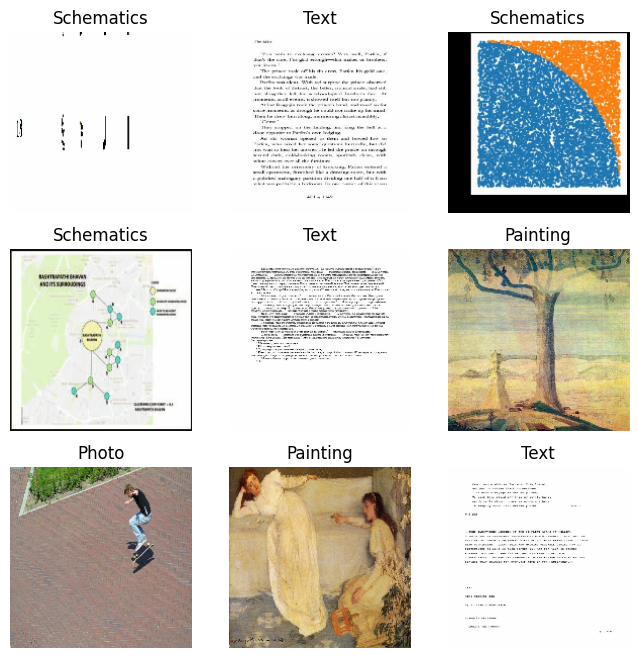

In [10]:
plt.figure(figsize = (8, 8))
for images, labels in train_set.take(10):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i].numpy()])
        plt.axis("off")

---

### 6. <a id='configuration'>Configuration de l'environnement</a>

Pour optimiser les performances des calculs, nous allons configurer les données à l’aide de deux fonctions : `Dataset.cache` et `Dataset.prefetch`.  
- [`Dataset.cache`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#cache) stocke les données en mémoire pour éviter les accès répétés au disque.  
- [`Dataset.prefetch`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#prefetch) permet de traiter un élément en arrière-plan pendant l'entraînement ou l'évaluation.  

En combinant ces techniques, nous réduirons significativement le temps de traitement et la charge computationnelle.

In [11]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_set = train_set.cache().shuffle(1000).prefetch(buffer_size = AUTOTUNE)
test_set = test_set.cache().prefetch(buffer_size = AUTOTUNE)

---

### 7. <a id='architecture'>Choix de l'architecture</a>

Les **Convolutional Neural Networks (CNN)** sont devenus l’architecture de référence pour les tâches de classification d’images, notamment en classification multi-classes. Leur efficacité repose sur leur capacité à exploiter la structure spatiale locale des images à travers des opérations de convolution, permettant ainsi une extraction hiérarchique des caractéristiques visuelles (bords, formes, textures…).

Historiquement, LeCun et al. (1998) ont démontré la pertinence des CNN dans la reconnaissance de chiffres manuscrits avec LeNet-5. Cette approche a été fortement étendue avec AlexNet (Krizhevsky et al., 2012), qui a surpassé toutes les autres méthodes sur le défi ImageNet, impliquant la classification dans 1000 classes différentes. Depuis, des architectures plus profondes comme VGG, ResNet ou EfficientNet ont confirmé la domination des CNN dans ce domaine (Rawat & Wang, 2017).

De nombreux frameworks modernes (TensorFlow, PyTorch) proposent des implémentations standardisées de CNN pour la classification multi-classes, et les performances obtenues dépassent largement celles des méthodes classiques (SVM, k-NN, etc.) sur des datasets variés.

En résumé, le choix d’un CNN est justifié par :
- Sa capacité à apprendre automatiquement des représentations visuelles pertinentes
- Son efficacité démontrée sur des benchmarks multi-classes (ex : CIFAR-10, ImageNet)
- Sa large adoption dans la recherche et l’industrie pour les tâches de vision par ordinateur

**Sources**
1. Lecun, Yann & Bottou, Leon & Bengio, Y. & Haffner, Patrick. (1998). Gradient-Based Learning Applied to Document Recognition. Proceedings of the IEEE. 86. 2278 - 2324. 10.1109/5.726791.
2. Krizhevsky, Alex & Sutskever, Ilya & Hinton, Geoffrey. (2012). ImageNet Classification with Deep Convolutional Neural Networks. Neural Information Processing Systems. 25. 10.1145/3065386.
3. Rawat, Waseem & Wang, Zenghui. (2017). Deep Convolutional Neural Networks for Image Classification: A Comprehensive Review. Neural Computation. 29. 2352-2449. 10.1162/NECO_a_00990.

---

### 8. <a id='modele'>Réalisation du modèle</a>

Maintenant que le choix de l'architecture est fait, nous pouvons commencer à créer le modèle que nous allons utiliser pour classifier les images envoyées par l'entreprise.

Notre modèle sera structuré autour des blocs suivants :  
- Une **couche de rescaling** pour normaliser les valeurs des composantes RGB des pixels dans l'intervalle `[0;1]`.  
- Une **première convolution** avec 16 filtres de taille 3x3 (`Conv2D`), suivie d'un **max pooling** pour réduire la dimension spatiale.  
- Une **seconde convolution** utilisant 32 filtres de taille 3x3.  
- Une **troisième convolution** avec 64 filtres de taille 3x3.  
- Une **transformation en vecteur** via une opération d'aplatissement (`Flatten`).  
- Une **couche dense** de 128 unités pour capturer les caractéristiques extraites.  
- Enfin, une **sortie entièrement connectée** avec 1 unité, correspondant à la classe cible.  

In [12]:
num_classes = len(class_names)

def create_model(name, use_dropout = False, show_summary = True,lr=0.001,activation='relu'):
    model = keras.Sequential(name=name)
    activation = activation
    model.add(layers.Rescaling(1./255))
    model.add(layers.Conv2D(16, (3, 3), padding = 'same', activation = activation))
    model.add(layers.MaxPooling2D((2, 2)))
    
    if use_dropout:
        model.add(layers.Dropout(0.25))
    
    model.add(layers.Conv2D(32, (3, 3), padding = 'same', activation = activation))
    model.add(layers.Conv2D(64, (3, 3), padding = 'same', activation = activation))
    
    if use_dropout:
        model.add(layers.Dropout(0.25))
    
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation = activation))
    
    if use_dropout:
        model.add(layers.Dropout(0.5))
    
    
    model.add(layers.Dense(num_classes, activation = 'softmax'))
    model.compile(
        optimizer = keras.optimizers.Adam(learning_rate = lr),
        loss = keras.losses.SparseCategoricalCrossentropy(from_logits = False),
        metrics = ['accuracy']
    )
    
    if show_summary:
        model.summary()
    
    return model

In [13]:
model = create_model("Base")

Model: "Base"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [15]:
def build_model(hp):
    units = hp.Int("units", min_value=32, max_value=512, step=32)
    activation = hp.Choice("activation", ["relu", "tanh"])
    dropout = hp.Boolean("dropout")
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    # call existing model-building code with the hyperparameter values.
    model = create_model(
        name="Tuner",
        use_dropout=dropout,
        show_summary=False,
        lr=lr,
        activation=activation
    )
    return model

tuner = kt.Hyperband(
    hypermodel = build_model,
    objective = 'val_accuracy',
    max_epochs = 10,
    factor = 3,
    directory = 'hyperband',
    project_name = 'hyperband_test'
)
stop_early = keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 5,
    restore_best_weights = True
)

Reloading Tuner from hyperband\hyperband_test\tuner0.json


In [17]:
# Convert the train_set into NumPy arrays
#x_train = []
#y_train = []
#for images, labels in train_set:
##    x_train.append(images.numpy())
#    y_train.append(labels.numpy())

# Stack the lists into NumPy arrays
#x_train = np.concatenate(x_train, axis=0)
#y_train = np.concatenate(y_train, axis=0)

train_size = int(0.8 * len(train_set))  # 80% for training
val_size = len(train_set) - train_size  # 20% for validation

train_dataset = train_set.take(train_size)
val_dataset = train_set.skip(train_size)

tuner.search(train_dataset, validation_data=val_dataset, epochs=50, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 23 Complete [00h 46m 40s]
val_accuracy: 0.24924516677856445

Best val_accuracy So Far: 0.9978864789009094
Total elapsed time: 05h 34m 08s

Search: Running Trial #24

Value             |Best Value So Far |Hyperparameter
480               |416               |units
0.001             |0.001             |learning_rate
relu              |relu              |activation
True              |False             |dropout
0.00065596        |0.0011034         |lr
10                |10                |tuner/epochs
0                 |4                 |tuner/initial_epoch
0                 |1                 |tuner/bracket
0                 |1                 |tuner/round

Epoch 1/10
828/828 ━━━━━━━━━━━━━━━━━━━━ 250s 301ms/step - accuracy: 0.6249 - loss: 1.0372 - val_accuracy: 0.8140 - val_loss: 0.4339
Epoch 2/10
828/828 ━━━━━━━━━━━━━━━━━━━━ 261s 315ms/step - accuracy: 0.8133 - loss: 0.4484 - val_accuracy: 0.8709 - val_loss: 0.3203
Epoch 3/10
828/828 ━━━━━━━━━━━━━━━━━━━━ 257s 310ms/step - accuracy:

KeyboardInterrupt: 

L'optimiseur [`Adam`](https://www.tensorflow.org/api_docs/python/tf/keras/optimizers/Adam) est choisi pour sa capacité d'adaptation et sa rapidité de convergence. La fonction de perte [`SparseCategoricalCrossentropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy), quant à elle, est utilisée car jugée plus efficace en mémoire que d'autres fonctions et bien adaptée à la classification multi-classes.

---

### 9. <a id='train'>Entraînement et évaluation du modèle</a>

Avec le modèle créé, nous pouvons désormais procéder à son entraînement et à son évaluation avec les ensembles de données à notre disposition.

#### 9.1. <a>Graphiques</a>

Nous utilisons des graphiques afin de visualiser les courbes d’accuracy pour suivre en temps réel les performances du modèle sur les données d’entraînement et de validation. Cela permet de détecter rapidement les signes de surapprentissage ou de sous-apprentissage.

In [ ]:
tensorboard_callback = keras.callbacks.TensorBoard(
    log_dir = log_dir,
    histogram_freq = 1
)

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath = 'checkpoints/best_model.keras',
    monitor = 'val_accuracy',
    save_best_only = True,
    save_weights_only = False,
    mode = 'max',
    verbose = 1
)

callbacks = [tensorboard_callback, checkpoint_callback]

def train_model(model, train_set = train_set, test_set = test_set, epochs = 10):
    
    checkpoint_callback.filepath = f"checkpoints/best_{model.name.lower()}_model.keras"
    
    history = model.fit(
        train_set,
        validation_data = test_set,
        epochs = epochs,
        callbacks = callbacks
    )
    
    accuracy = history.history['accuracy']
    validation_accuracy = history.history['val_accuracy']
    
    epochs_range = range(epochs) if epochs == 10 else range(len(accuracy))
    
    loss = history.history['loss']
    validation_loss = history.history['val_loss']
    
    plt.figure(figsize = (16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, accuracy, label = 'Training Accuracy')
    plt.plot(epochs_range, validation_accuracy, label = 'Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f"Training and Validation Accuracy - {model.name}")
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label = 'Training Loss')
    plt.plot(epochs_range, validation_loss, label = 'Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f"Training and Validation Loss - {model.name}")
    
    plt.show()

In [ ]:
train_model(model)

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

──────────────────────────────────────────────────

#### 9.2. <a>Matrice de confusion</a>

Nous utilisons une matrice de confusion pour évaluer plus finement les performances d’un modèle en montrant les erreurs de classification pour chaque classe. Elle met en évidence les classes confondues et aide à cibler les axes d’amélioration.

In [ ]:
X_test = []
y_true = []

for images, labels in test_set:
    X_test.append(images)
    y_true.append(labels)

X_test = np.concatenate(X_test)
y_true = np.concatenate(y_true)

def display_matrix(model, X_test = X_test, y_true = y_true, class_names = class_names):
    y_pred_proba = model.predict(X_test)
    y_pred = np.argmax(y_pred_proba, axis = 1)
    cm = confusion_matrix(y_true, y_pred)
    display = ConfusionMatrixDisplay(cm, display_labels = class_names)
    display.plot(cmap = plt.cm.Blues)
    plt.title("Matrice de confusion")
    plt.xticks(rotation = 45)
    plt.show()

In [ ]:
display_matrix(model)

#### 9.3. <a>TensorBoard</a>

Nous utilisons TensorBoard pour visualiser de manière interactive l’entraînement du modèle, en suivant l’évolution des métriques, la structure du réseau et d’autres informations utiles pour le debug et l’optimisation.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

---

### 10. <a id='amelioration'>Amélioration du modèle</a>

Afin de palier au surapprentissage observé et d’améliorer la généralisation du modèle, plusieurs techniques de régularisation ont été retenues :

- [Data Augmentation](#augmentation): Cette technique consister à générer artificiellement de nouvelles images en appliquant des transformations aléatoires aux données existantes. Elle permet d'améliorer la généralisation du modèle en le rendant plus robuste aux variations comme l’orientation, la luminosité ou le zoom.

- [Dropout](#dropout) : Cette méthode consiste à désactiver aléatoirement un certain pourcentage de neurones à chaque itération lors de l'entraînement. Cela empêche le modèle de devenir trop dépendant de certaines connexions et encourage l'apprentissage de représentations plus robustes. Une valeur typique se situe entre 0.2 et 0.5 selon la complexité du réseau.

- [Early-Stopping](#early-stopping) : Cette technique permet d'arrêter automatiquement l'entraînement lorsque la performance sur l’ensemble de validation commence à se dégrader. Elle évite d’entraîner le modèle trop longtemps, ce qui pourrait mener à un surajustement aux données d’entraînement. Un paramètre clé est la `patience`, qui définit le nombre d’époques d'attente avant d'interrompre l'entraînement si aucune amélioration n'est observée.

En testant et, potentiellement, combinant ces différentes approches, nous parviendrons à obtenir un modèle plus stable, robuste, et capable de mieux généraliser sur des données non vues.

──────────────────────────────────────────────────

#### 10.1. <a id='augmentation'>Data Augmentation</a>

Pour cette approche, nous allons appliquer des transformations aux données d'entraînement, comme un retournement aléatoire, une rotation de 10% et d’un zoom vertical de 10%. Les données de test restent inchangées pour permettre au modèle de pouvoir faire des prédictions sur un cas réel.

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip(input_shape = (image_h, image_w, 3), mode = 'horizontal_and_vertical'),
    layers.RandomRotation(factor = 0.1, fill_mode = 'nearest'),
    layers.RandomZoom(height_factor = 0.1, fill_mode = 'nearest'),
])

augmented_train_set = train_set.map(lambda x, y: (data_augmentation(x, training = True), y))

In [ ]:
model_with_augmentation = create_model("Augmentation")

Nous pouvons procéder à l'entraînement de cette version du modèle.

In [ ]:
train_model(model_with_augmentation, train_set = augmented_train_set)

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

&nbsp;

**Notes lors des tests (avec le dataset du WKS2)**
- Méthode efficace pour gérer le surapprentissage
- Les courbes d'accuracy augmentent ensemble de manière cohérente
- Pas de divergence apparente
- Très bonne capacité de généralisation vu que la courbe de Validation Accuracy est souvent au-dessus de celle de la Training Accuracy

In [ ]:
display_matrix(model_with_augmentation)

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

──────────────────────────────────────────────────

#### 10.2. <a id='dropout'>Dropout</a>

Pour cette approche, nous ajoutons un Dropout de 25% après le MaxPooling et un Dropout de 50% après la couche Dense, en s'inspirant de l’approche de [Keras pour le dataset MNIST](https://github.com/keras-team/keras/blob/keras-2/examples/mnist_cnn.py). Le premier limite la dépendance aux caractéristiques extraites, tandis que le second réduit le surajustement dans la partie dense.

In [ ]:
model_with_dropout = create_model("Dropout", use_dropout = True)

Nous pouvons procéder à l'entraînement de cette version du modèle.

In [ ]:
train_model(model_with_dropout)

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

&nbsp;

**Notes lors des tests (avec le dataset du WKS2)**
- Apprend trop vite (Traning Accuracy > 95%) mais ne généralise pas mieux pour autant (Validation Loss en hausse)
- La Validation Accuracy se stabilise au bout de la 6ème époque
- Écart significatif entre la Traning Accuracy et la Validation Accuracy => surapprentissage
- Le Dropout seul semble ne pas suffire

In [ ]:
display_matrix(model_with_dropout)

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

──────────────────────────────────────────────────

#### 10.3. <a id='early-stopping'>Early Stopping</a>

Pour cette approche, nous ajoutons un Early Stopping basé sur la perte de validation, avec une patience de 5 époques, afin d’interrompre l’entraînement dès que le modèle cesse de s’améliorer et de conserver les meilleurs poids.

In [ ]:
early_stopping = keras.callbacks.EarlyStopping(
    monitor = 'val_accuracy',
    patience = 2,
    mode = 'max',
    restore_best_weights = True
)

In [ ]:
model_with_early_stopping = create_model("Early Stopping")

Nous pouvons procéder à l'entraînement de cette version du modèle.

In [ ]:
callbacks.append(early_stopping)
train_model(model_with_early_stopping, epochs = 20)
callbacks.pop()

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

&nbsp;

**Notes lors des tests (avec le dataset du WKS2)**
- Apprend trop vite (Traning Accuracy > 95%) mais ne généralise pas mieux pour autant
- Traning Accuracy proche de 100% à la fin + écart avec Validation Accuracy => surapprentissage
- La Validation Loss augmente, ce qui est un autre signe du surapprentissage
- Méthode insuffisante à elle seule pour prévenir l'overfitting

In [ ]:
display_matrix(model_with_early_stopping)

<b style="color:yellow;">TODO</b>

Analyser les résultats obtenus.

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs/fit

──────────────────────────────────────────────────

<b style="color:yellow;">TODO</b>

Écrire un texte permettant de faire le point sur les tests individuels des méthodes de régularisation et établir quelle(s) méthode(s) est / sont choisie(s).

Si il y a combinaison, il faudrait refaire des bouts de code pour créer le modèle, l'entraîner, etc...

---

### 11. <a id='tuning'>Tuning des hyperparamètres du modèle</a>

<b style="color:yellow;">TODO</b>

Se renseigner sur le tuning des hyperparamètres, voir si c'est faisable / conseillé / nécessaire.

---

### 12. <a id='final'>Modèle final</a>

<b style="color:yellow;">TODO</b>

Indiquer et justifier le choix du modèle final à l'aide des résultats observés. Faire la passe sur ses caractéristiques, à savoir :
- Paramètres
- Fonction de perte
- Algorithme d'optimisation utilisé pour l'entraînement

Inclure un schéma du modèle réalisé grâce à cet [outil](https://alexlenail.me/NN-SVG/LeNet.html).

---

### 13. <a id='conclusion'>Conclusion</a>

<b style="color:yellow;">TODO</b>

Écrire la conclusion.

---